# Data Transformation by Attribute Normalization — Z-Score Normalization

> This notebook is a hands-on demo that accompanies the slide **‘Data Transformation by Attribute Normalization — Z-Score Normalization’**.

**What you will learn**
- What Z-score (standard) normalization is and why we use it
- The formula and a quick by-hand calculation
- How to use `scikit-learn`'s `StandardScaler`
- What happens to the mean and standard deviation after scaling
- How outliers affect Z-scores (and how this differs from Min–Max)
- How to reverse the transform with `inverse_transform`

## 0. Setup (packages)
If this is your first time running in VS Code, execute the cell below to install dependencies.

In [ ]:
%pip -q install numpy pandas matplotlib seaborn scikit-learn

## 1. Imports & Reproducibility

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (9, 4)

## 2. Concept — What is Z-Score Normalization?
Z-score normalization (a.k.a. *standardization*) rescales a feature so that it has **mean 0** and **standard deviation 1** (approximately, on the data used to fit the scaler).

**Formula:**
$z = \frac{x - \mu}{\sigma}$

- $x$ is the original value
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation of the feature

Intuition: it tells us *how many standard deviations above or below the mean* a value is.

## 3. By-hand example (linked to the slide)
Suppose the average income is $\mu = 54,000$ with standard deviation $\sigma = 12,000$. What is the Z-score for $x = 73,600$?

In [2]:
mu, sigma = 54000, 12000
x = 73600
z = (x - mu) / sigma
z

1.6333333333333333

**Interpretation:** if the result were `1.63`, it would mean the income is **1.63 standard deviations above** the mean.

## 4. Create a small dataset to visualize
We'll generate a toy dataset with two features: `income` (skewed) and `spend_score` (roughly normal).

In [3]:
n = 220
income = np.concatenate([
    np.random.normal(60000, 8000, size=190),
    np.random.normal(95000, 6000, size=25),
    np.array([180000, 220000, 300000, 450000, 520000])  # a few high outliers
])
income = np.clip(income, 15000, 600000)
spend_score = np.random.normal(50, 12, size=len(income))
df = pd.DataFrame({'income': income.astype(int), 'spend_score': spend_score})
df.head()

,income,spend_score
0,63973,59.107631
1,58893,40.726097
2,65181,47.158177
3,72184,44.175637
4,58126,50.982490


### Distributions before standardization

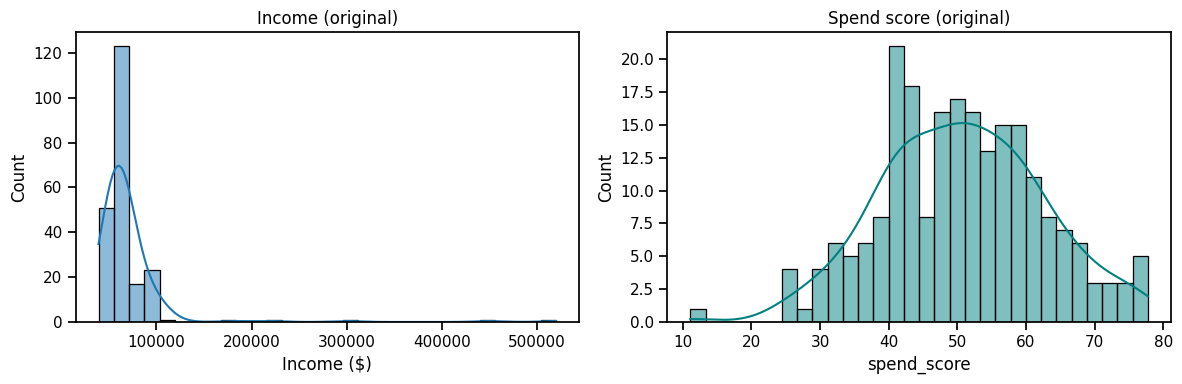

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['income'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Income (original)')
axes[0].set_xlabel('Income ($)')
sns.histplot(df['spend_score'], bins=30, kde=True, color='teal', ax=axes[1])
axes[1].set_title('Spend score (original)')
plt.tight_layout(); plt.show()

## 5. Apply Z-score normalization with `StandardScaler`
`StandardScaler` standardizes each column: subtracts its mean and divides by its standard deviation (using population standard deviation, `ddof=0`).

In [5]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df[['income', 'spend_score']])
df_std = pd.DataFrame(scaled, columns=['income_z', 'spend_score_z'])
df2 = pd.concat([df, df_std], axis=1)
df2.head()

,income,spend_score,income_z,spend_score_z
0,63973,59.107631,-0.132200,0.722142
1,58893,40.726097,-0.240506,-0.844401
2,65181,47.158177,-0.106445,-0.296235
3,72184,44.175637,0.042860,-0.550418
4,58126,50.982490,-0.256859,0.029687


### Check the new mean and std (should be ~0 and ~1)

In [6]:
df2[['income_z','spend_score_z']].agg(['mean','std']).round(4)

,income_z,spend_score_z
mean,0.0000,0.0000
std,1.0023,1.0023


### Visualize after standardization

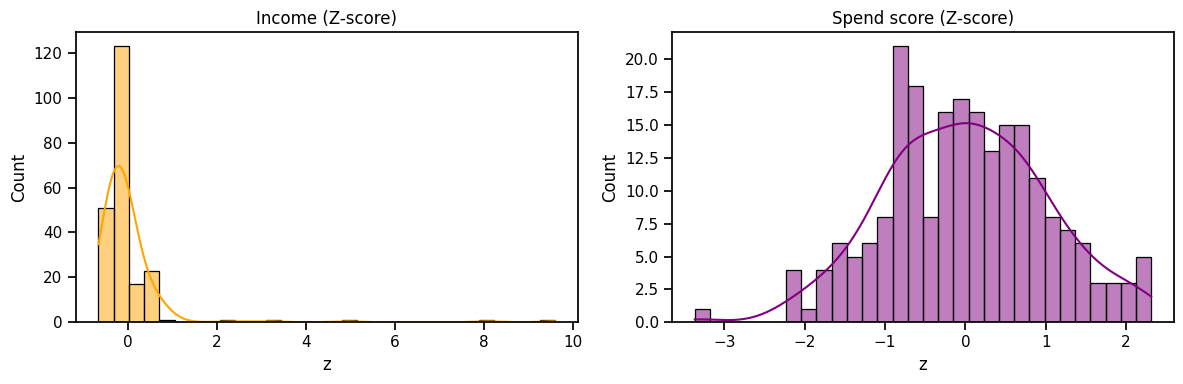

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df2['income_z'], bins=30, kde=True, ax=axes[0], color='orange')
axes[0].set_title('Income (Z-score)')
axes[0].set_xlabel('z')
sns.histplot(df2['spend_score_z'], bins=30, kde=True, ax=axes[1], color='purple')
axes[1].set_title('Spend score (Z-score)')
axes[1].set_xlabel('z')
plt.tight_layout(); plt.show()

## 6. Compare features on the same scale
After standardization, features with very different units become comparable. For example, we can overlay their standardized distributions.

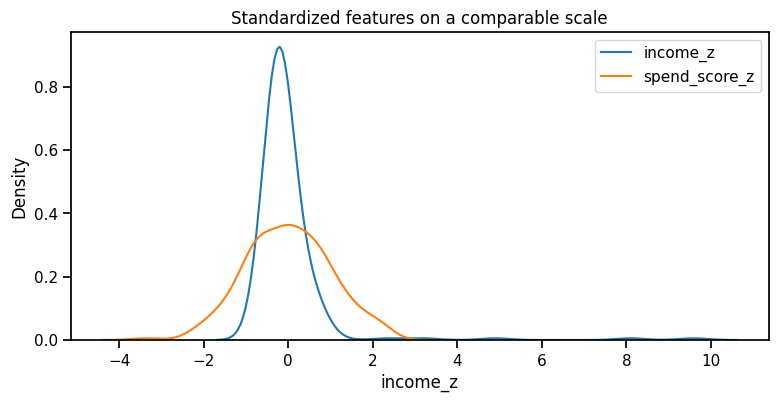

In [8]:
fig, ax = plt.subplots()
sns.kdeplot(df2['income_z'], ax=ax, label='income_z')
sns.kdeplot(df2['spend_score_z'], ax=ax, label='spend_score_z')
ax.set_title('Standardized features on a comparable scale')
ax.legend(); plt.show()

## 7. Inverse transform (go back to original units)
You can reverse the transform to interpret model outputs in the original units.

In [ ]:
samples_z = np.array([[0.0,  0.0],   # mean
                         [1.0, -1.5],
                         [-0.5, 2.0]])
recovered = scaler.inverse_transform(samples_z)
pd.DataFrame(recovered, columns=['income($)','spend_score']).round(2)

## 8. Outlier influence (caveat)
Z-scores are **less sensitive** to outliers than Min–Max scaling because they don't force all values into a fixed interval. However, the mean ($\mu$) and standard deviation ($\sigma$) are still affected by extreme values, so standardized values can still shift.

In [ ]:
# Remove the most extreme outliers and compare means/stds
df_no_out = df[df['income'] < 200000].copy()
sc_no_out = StandardScaler().fit(df_no_out[['income']])
sc_with_out = StandardScaler().fit(df[['income']])
pd.DataFrame({
    'case': ['without_outliers', 'with_outliers'],
    'mean_used': [sc_no_out.mean_[0], sc_with_out.mean_[0]],
    'scale_used(σ)': [sc_no_out.scale_[0], sc_with_out.scale_[0]]
}).round(2)

**Takeaway:** Outliers still influence $\mu$ and $\sigma$. Consider trimming, winsorizing, or using robust scalers (median/IQR) if outliers are severe.

## 9. Sample vs population standard deviation
`StandardScaler` uses the **population** standard deviation (`ddof = 0`). In contrast, many statistics courses use the **sample** standard deviation (`ddof = 1`). The values will be close for large samples but may differ for small samples.

In [ ]:
x = np.array([1., 2., 3., 4., 5.])
pop_std = x.std(ddof=0)
samp_std = x.std(ddof=1)
pop_std, samp_std

## 10. Practice exercises (for students)
1. Standardize only `income`, fit the scaler on a **train split** and reuse it on a **test split**. Verify no leakage.
2. Compute z-scores manually using your own function and compare with `StandardScaler` outputs.
3. Add/removes outliers and observe how `mean_` and `scale_` change.
4. Create a scatter plot of (`income_z`, `spend_score_z`). What do you notice vs. the original units?
5. (Challenge) Compare a k-NN model's performance before and after standardization.

---
_Last updated: 2026-02-17 16:06:33 UTC_